In [10]:
from anomaly_detection.config.config_handler import get_config
config = get_config('/home/ssulta24/Desktop/VCAE_new/anomaly_detection/config/config.yaml')
from anomaly_detection.data.data_loader_V2 import EELSDataset
data = EELSDataset(config)
dataset = data.get_preprocessed_data()
energy_values = data.get_cropped_energy_values()

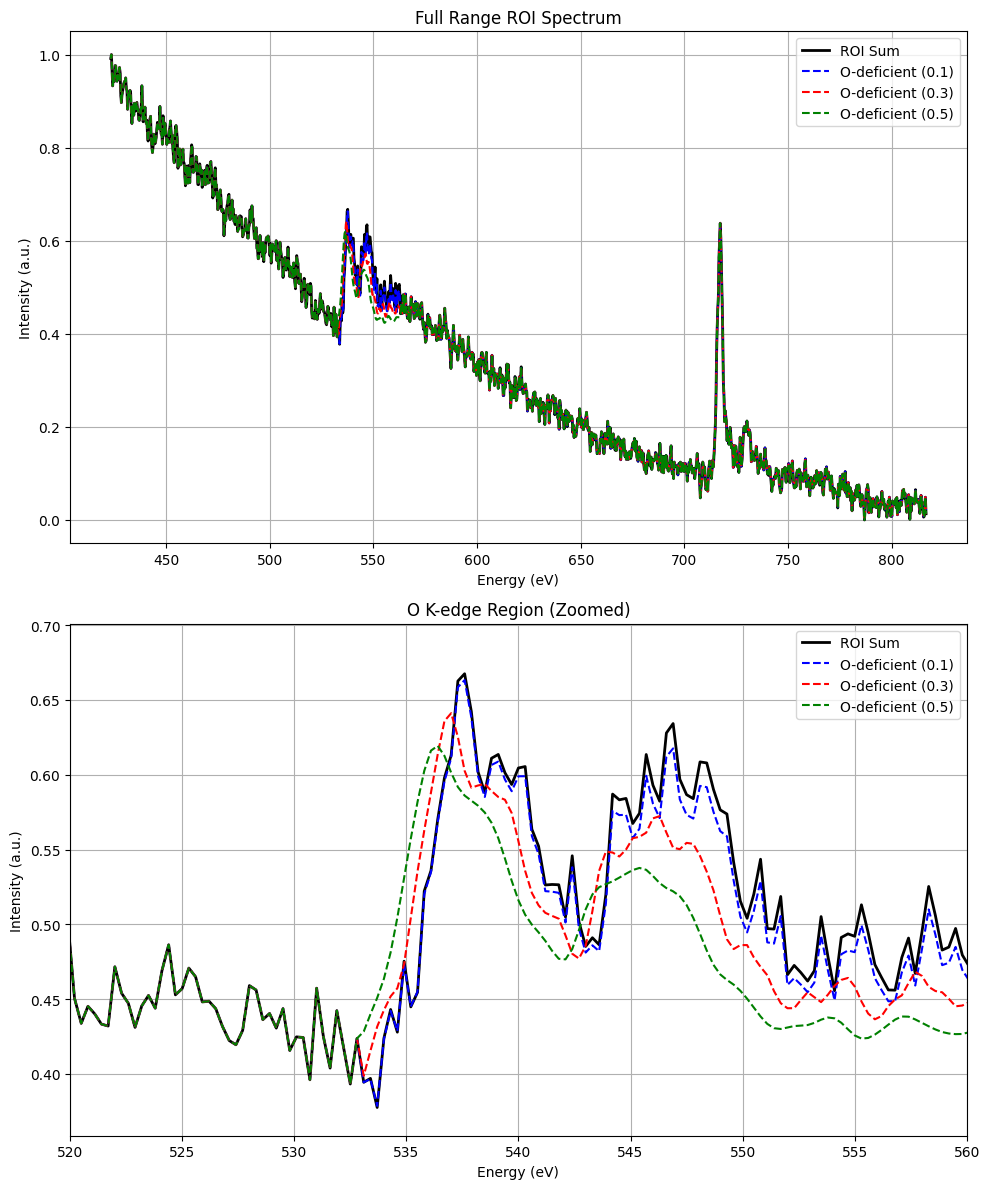

In [44]:
import numpy as np
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt

def get_roi_spectrum(data, spatial_dimensions, roi_size=10):
    """
    Extract and sum spectrum from a region of interest
    
    Parameters:
    -----------
    data : ndarray
        Full dataset with spatial and energy dimensions
    spatial_dimensions : tuple
        Size of spatial dimensions
    roi_size : int
        Size of ROI in pixels
    
    Returns:
    --------
    array-like : Summed spectrum from ROI
    """
    # Ensure ROI size doesn't exceed dimensions
    roi_size = min(10, min(spatial_dimensions))
    
    # Calculate ROI coordinates
    roi_start = tuple([min(50, dim - roi_size) for dim in spatial_dimensions])
    roi_end = tuple([start + roi_size for start in roi_start])
    
    # Create ROI slice
    roi_slice = tuple(slice(start, end) for start, end in zip(roi_start, roi_end))
    
    # Sum spectrum in ROI
    roi_spectrum = np.sum(data[roi_slice], axis=tuple(range(data.ndim - 1)))
    
    return roi_spectrum

def simulate_oxygen_deficiency(original_spec, energy_range, deficiency_level=0.1, ok_edge_start=533):
    """
    Simulate oxygen deficiency with effects only applied to O K-edge region and beyond
    
    Parameters:
    -----------
    original_spec : array-like
        Original XAS spectrum
    energy_range : array-like
        Energy values
    deficiency_level : float
        Degree of oxygen deficiency to simulate (0-1)
    ok_edge_start : float
        Energy value where O K-edge region starts
    """
    # Create mask for O K-edge region and beyond
    ok_edge_mask = (energy_range >= ok_edge_start) & (energy_range <= ok_edge_start + 30)
    
    # Create modified spectrum
    modified_spec = original_spec.copy()
    
    # Only apply effects to O K-edge region
    edge_energies = energy_range[ok_edge_mask]
    edge_spec = modified_spec[ok_edge_mask]
    
    # Normalize the O K-edge portion
    edge_spec = (edge_spec - np.min(edge_spec)) / (np.max(edge_spec) - np.min(edge_spec))
    
    # Create energy normalization only for O K-edge region
    energy_normalized = (edge_energies - np.min(edge_energies)) / (np.max(edge_energies) - np.min(edge_energies))
    
    # Create sigmoid transitions for amplitude reduction
    sigmoid1 = 1 / (1 + np.exp(-(energy_normalized - 0.3) * 10))
    sigmoid2 = 1 / (1 + np.exp(-(energy_normalized - 0.6) * 15))
    
    # Combine sigmoids for complex amplitude reduction pattern
    amplitude_factor = 1 - (deficiency_level * (0.7 * sigmoid1 + 0.3 * sigmoid2))
    
    # Apply amplitude reduction only to edge region
    edge_spec *= amplitude_factor
    
    # Apply gaussian blur with varying sigma only to edge region
    sigma = deficiency_level * (0.5 + energy_normalized * 3.0)
    edge_spec = gaussian_filter1d(edge_spec, sigma=np.max(sigma))
    
    # Apply small shift only to edge region
    shift_amount = int(deficiency_level * 8)
    edge_spec = np.roll(edge_spec, -shift_amount)
    if shift_amount > 0:
        edge_spec[-shift_amount:] = edge_spec[-(shift_amount+1)]
    
    # Rescale edge_spec back to original range
    edge_range = np.max(original_spec[ok_edge_mask]) - np.min(original_spec[ok_edge_mask])
    edge_min = np.min(original_spec[ok_edge_mask])
    edge_spec = (edge_spec * edge_range) + edge_min
    
    # Insert modified edge region back into spectrum
    modified_spec[ok_edge_mask] = edge_spec
    
    return modified_spec
    
def plot_roi_and_deficiency(energy_range, roi_spectrum, deficiency_levels=[0.1, 0.2, 0.3]):
    """
    Plot ROI spectrum and simulated deficient spectra
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
    
    # Full range plot
    ax1.plot(energy_range, roi_spectrum, 'k-', label='ROI Sum', linewidth=2)
    for level, color in zip(deficiency_levels, ['b', 'r', 'g']):
        deficient_spec = simulate_oxygen_deficiency(roi_spectrum, energy_range, level)
        ax1.plot(energy_range, deficient_spec, 
                color=color, 
                label=f'O-deficient ({level:.1f})',
                linestyle='--')
    
    ax1.set_xlabel('Energy (eV)')
    ax1.set_ylabel('Intensity (a.u.)')
    ax1.set_title('Full Range ROI Spectrum')
    ax1.legend()
    ax1.grid(True)
    
    # Zoomed O K-edge plot
    ax2.plot(energy_range, roi_spectrum, 'k-', label='ROI Sum', linewidth=2)
    for level, color in zip(deficiency_levels, ['b', 'r', 'g']):
        deficient_spec = simulate_oxygen_deficiency(roi_spectrum, energy_range, level)
        ax2.plot(energy_range, deficient_spec, 
                color=color, 
                label=f'O-deficient ({level:.1f})',
                linestyle='--')
    
    # Set zoom range for O K-edge
    ax2.set_xlim(520, 560)
    
    # Find y-limits based on data in the zoomed region
    mask = (energy_range >= 520) & (energy_range <= 560)
    y_min = min(roi_spectrum[mask]) * 0.95
    y_max = max(roi_spectrum[mask]) * 1.05
    ax2.set_ylim(y_min, y_max)
    
    ax2.set_xlabel('Energy (eV)')
    ax2.set_ylabel('Intensity (a.u.)')
    ax2.set_title('O K-edge Region (Zoomed)')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    return fig

# Function to save modified spectrum
def save_deficient_spectrum(energy_range, modified_spec, filename='modified_spectrum.txt'):
    """
    Save the modified spectrum to a file
    """
    np.savetxt(filename, np.column_stack([energy_range, modified_spec]))

pixel_y, pixel_x = (102,102)
original_spec = dataset[pixel_y, pixel_x]

# Get ROI spectrum
roi_spectrum = get_roi_spectrum(dataset, (210, 210))

roi_spectrum = (roi_spectrum - np.min(roi_spectrum)) / (np.max(roi_spectrum) - np.min(roi_spectrum))

# Create and plot with zoomed view
fig = plot_roi_and_deficiency(energy_values, roi_spectrum, deficiency_levels=[0.1, 0.3, 0.5])